# Lecture 06 Code Simulation 

In [1]:

#%% Load various libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt

from statsmodels.graphics.tsaplots import plot_acf      # import ACF plot
from statsmodels.graphics.tsaplots import plot_pacf     # import PACF plot
from statsmodels.stats.diagnostic import acorr_ljungbox # import Ljung-Box Test
from statsmodels.tsa.arima_process import arma_generate_sample  # simulate ARMA process


In [2]:
# Plot funtion to dsiplay both the time sereis, acf and pacf
# as deafualt it displays 25 lags,
# This code was adapted from the blog Seanabu.com
def tsplot(y, lags=25, figsize=(10, 8), style='bmh'):
    
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        plt.figure(figsize=figsize) # Set the size of the figure
        
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')


        plt.tight_layout()
    return 


# Plot function to displaythe standardized residuals, ACF and Ljung-Box test-
# statiticics p-values. As deafualt it displays 25 lags,
# This code was adapted from the blog Seanabu.com
def tsdiag(arimaResiduals, afcFags=25, lbLags = 10, figsize=(10, 8), style='bmh'):
    
    if not isinstance(arimaResiduals, pd.Series):
        arimaFittedvVlues = pd.Series(arimaResiduals)
        
    with plt.style.context(style):    
        plt.figure(figsize=figsize) # Set the size of the figure
    
        layout = (3, 1)
        sr_ax = plt.subplot2grid(layout, (0, 0))
        acf_ax = plt.subplot2grid(layout, (1, 0))
        lb_ax = plt.subplot2grid(layout, (2, 0))
        
        # Create the standard residual plot
        sr_ax.plot(arimaFittedvVlues)
        sr_ax.set_title("Standardizede Residuals")
        sr_ax.set_xlabel("Time")
    
        # Crate the ACF plot
        plot_acf(arimaResiduals, lags=afcFags, ax=acf_ax)
        
        # Create the Ljung-Box statitics plot
        lb = acorr_ljungbox(arimaResiduals, lags = lbLags)
        lbPvalue = lb[1] # get the pvalue from the ljungbox test
        
        lb_ax.scatter(np.arange(lbLags), lbPvalue,  facecolors='none', edgecolors='b')
        lb_ax.set_ylim(-0.1, 1)
        lb_ax.axhline(y=0.05, linestyle ='--')
        lb_ax.set_title("p values for Ljung-Box Statistic")
        lb_ax.set_ylabel("p values")
        lb_ax.set_xlabel("lags")
    
    
        plt.tight_layout()
    return


# The function apply the numpy function cumsum multiple times on the same 
# the same array. Used for simulating the integrated part in ARIMA models.
def cusumRepeat(arma, d):
    if d == 0:
        return(arma)
        
    return(cusumRepeat(np.cumsum(arma), d-1))

# Function to simulate ARIMA model as the python package statsmodels only
# supports simulations of ARMA models
def simArima(n, ar = np.array([0]), ma = np.array([0]), d = 0):
    
    if np.array_equal(ar, np.array([0])) and np.array_equal(ma, np.array([0])):
        print("Neither autoregressive parameters and moving average parameters are set. At least one need to be speficifyed")
        return -1
        
    ar = np.r_[1, -arParams]  # add zero-lag and negate
    ma = np.r_[1, maParams]   # add zero-lag
    
    arimaSim = arma_generate_sample(ar, ma, n)
    
    # Apply integration to the arma simulation
    if d > 0:
       arimaSim = cusumRepeat(arimaSim, d)
    
    return arimaSim

## Simulating an ARIMA(1,1,0) model

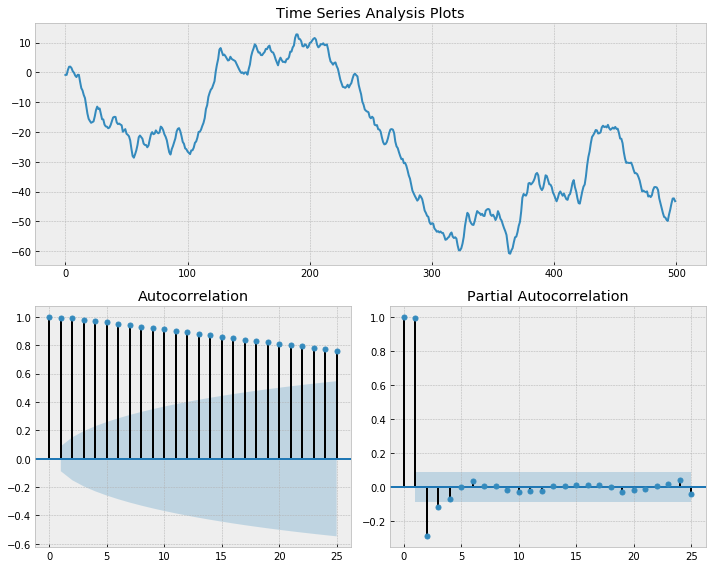

In [15]:
nSample = 500

arParams = np.array([0.6]) # Auto Regresive parameters
maParams = np.array([0])    # Moving Average parameters
dParam = 1                  # Integrated parameter

sim1 = simArima(n = nSample, ar = arParams, ma = maParams, d = dParam)
tsplot(sim1)                # Plot the time series, ACF and PACF

## Simulating an AR(1) - same as above just without d = 0

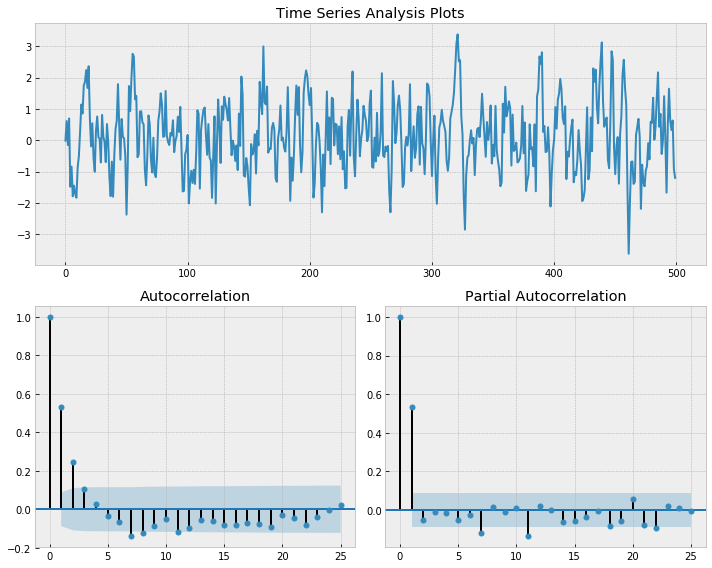

In [16]:
nsample = 500

arParams = np.array([0.6]) # Auto Regresive parameters
maParams = np.array([0])    # Moving Average parameters

sim2 = simArima(n = nsample, ar = arParams, ma = maParams)
tsplot(sim2) # Plot the time series, ACF and PACF

## How does the diff of 'sim1' to compare with 'sim2'

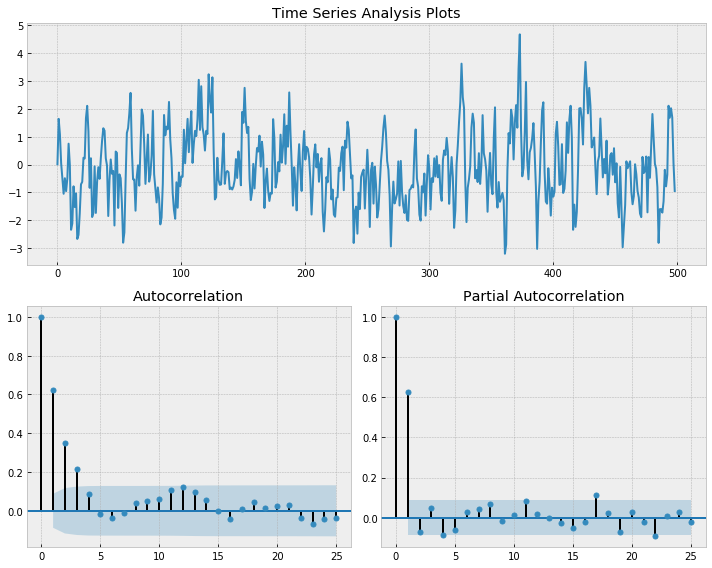

In [19]:
a = np.diff(sim1)
tsplot(a) 

## The ACF og White Noise Signal
In the below code we generate 100 random normal distributed numbers and investigate the ACF.

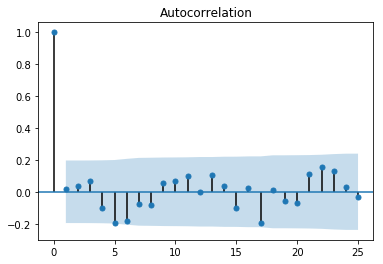

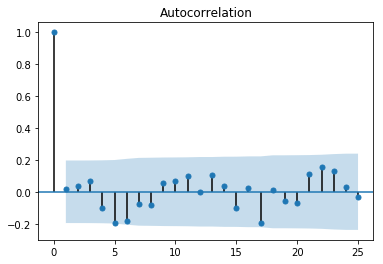

In [20]:
mu, sigma = 0, 1 # mean and standard deviation
rn = np.random.normal(mu, sigma, 100)   # Simulate 100 random normal distribued numbers
plot_acf(rn, lags=25)

## Estimating parameters (In this case a too complex model  i.e ARIMA(2,1,0))
NB: Next lecture will have focus on how the estimation works

To estimate the arima parameter we will use the function ARIMA from the statsmodels.tsa.api  library. Note the function returns the class statsmodels.tsa.arima_model.ARIMAResults. For information of the class please check out
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html

In [27]:
a1 = smt.ARIMA(sim1, order = (2,1,1)).fit(method='mle', trend='nc')

To get a summarize of the model we can apply **.summary** function. 

In [28]:
a1.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -707.191
Method:                           mle   S.D. of innovations              0.998
Date:                Fri, 22 Mar 2019   AIC                           1422.383
Time:                        14:28:04   BIC                           1439.233
Sample:                             1   HQIC                          1428.995
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.1646      0.260      0.633      0.527      -0.345       0.674
ar.L2.D.y      0.2408      0.174      1.383      0.167      -0.101       0.582
ma.L1.D.y      0.5142      0.250      2.057      0.040       0.024       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7245           +0.0000j            1.7245            0.0000
AR.2           -2.4083           +0.0000j            2.4083            0.5000
MA.1           -1.9449           +0.0000j            1.9449            0.5000
-----------------------------------------------------------------------------
"""

To get the time series diagnostic plot we can use the function tsdiag implemented in the top of script.

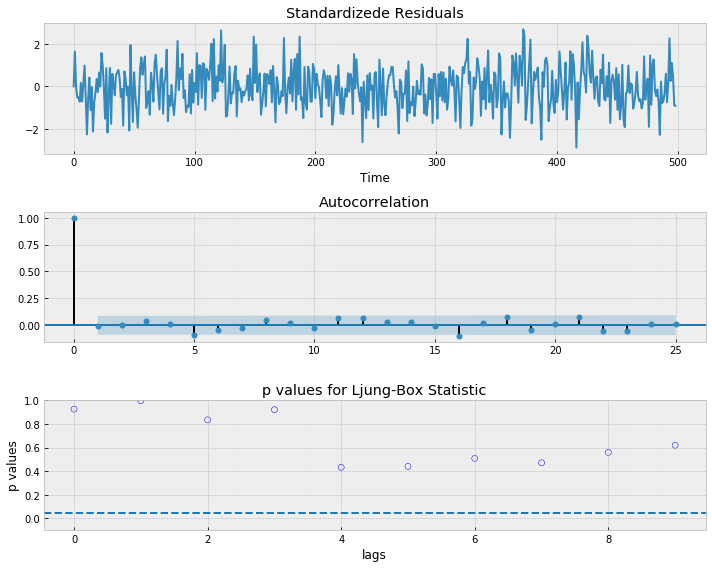

In [29]:
tsdiag(a1.resid) 

## Estimating parameters (In this case the right model i.e ARIMA(1,1,0))

In [46]:
a2 = smt.ARIMA(sim1, order = (1,1,0)).fit(method='mle', trend='nc')
a2.summary(alpha=0.05) # Summarise the fitted model

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -709.263
Method:                           mle   S.D. of innovations              1.002
Date:                Fri, 22 Mar 2019   AIC                           1422.526
Time:                        14:40:29   BIC                           1430.952
Sample:                             1   HQIC                          1425.833
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      0.6255      0.035     17.956      0.000       0.557       0.694
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5987           +0.0000j            1.5987            0.0000
-----------------------------------------------------------------------------
"""

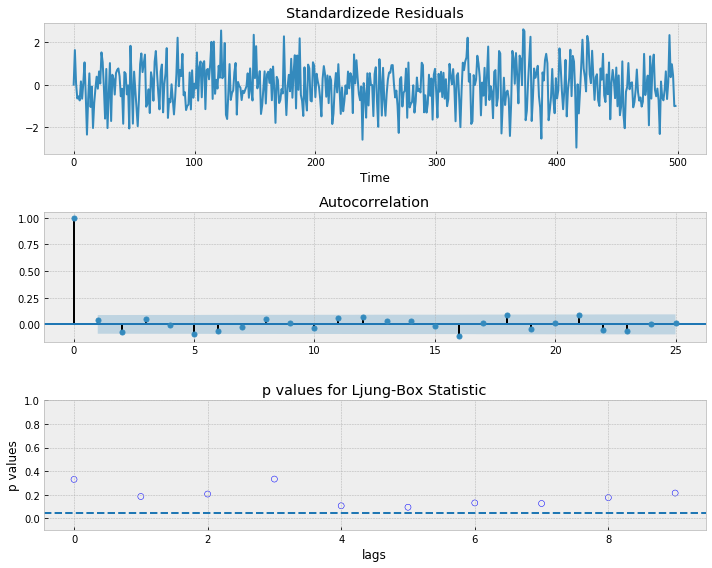

In [33]:
tsdiag(a2.resid) # Plot time series diagnostic plot

## Simulating a seasonal AR(1) model with season 12
$AR(1)_{s=12}$
The simArima doesn't handle seasonal models but we can just specify the polynomial n B rather than in B^s:


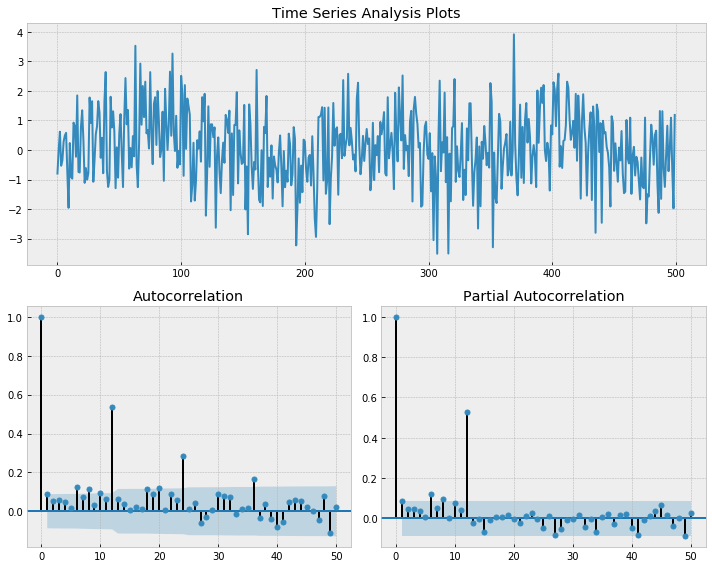

In [35]:
nSample = 500
arParams = np.concatenate( (np.zeros(11), np.array([0.6]) ), axis = 0) # Auto Regresive parameters

sim3 = simArima(n = nSample, ar = arParams)
tsplot(sim3, lags = 50)

Adding theoretical ACF values to the ACF plot. The theoretical ACF is marked with red.

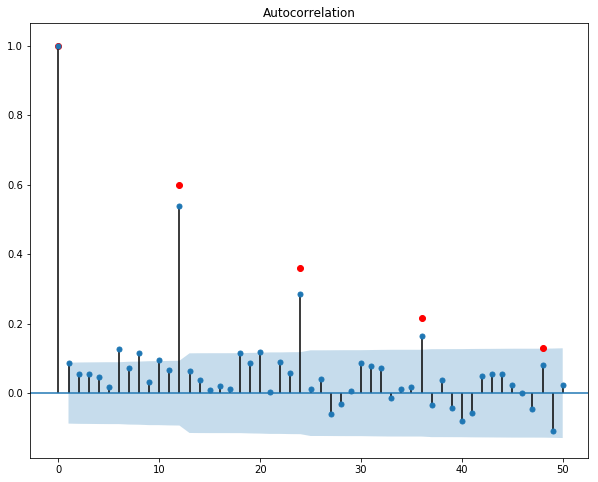

In [37]:
plt.figure(figsize=(10, 8))
acf_ax = plt.subplot(1, 1, 1)
plot_acf(sim3, lags=50, ax = acf_ax)

x = np.arange(5)*12
y = np.power(0.6*np.ones(5), np.arange(5))
acf_ax.scatter(x, y, marker = 'o', color = "red")
plt.show()